# STA 141B Assignment 4

Due __Feb 22, 2019__ by 11:59pm. Submit by editing this file, committing the changes with git, and then pushing to your private GitHub repo for the assignment. This assignment will be graded according to the class rubric.

Please do not rename this file or delete the exercise cells, because it will interfere with our grading tools. Put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text. Answer all questions with complete sentences.

The purpose of this assignment is to practice scraping data from web pages.

## The San Francisco Chronicle

In this assignment, you'll scrape text from [The San Francisco Chronicle](https://www.sfchronicle.com/) newspaper and then analyze the text.

The Chronicle is organized by category into article lists. For example, there's a [Local](https://www.sfchronicle.com/local/) list, [Sports](https://www.sfchronicle.com/sports/) list, and [Food](https://www.sfchronicle.com/food/) list.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Chronicle for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in a Chronicle article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Return a list of article URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* You can use any of the XML/HTML parsing packages mentioned in class. Choose one and use it throughout the entire assignment.

In [66]:
# load the packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp 

import lxml.html as lx
import requests
import requests_cache

requests_cache.install_cache("mycache")

import re
import nltk
from nltk.corpus import wordnet

import seaborn as sns
%matplotlib inline

In [14]:
def article_list(url):
    '''This function return a list of article URLs.'''
    #url = "https://www.sfchronicle.com/local/"
    response = requests.get(url) # request to get the url
    response.raise_for_status() # check the status
    html = lx.fromstring(response.text) # get text
    html.make_links_absolute(url) # makes all links in the document absolut

    lks = html.xpath("//*[contains(@class, 'headline')]/a/@href")
    lks = html.xpath("//*[not(@class)]/a/@href") + lks
    # we have to path to get the all links, and can make sure the links are all articles and not ads
    lks = {x for x in lks} #set uniq
    lks = [str(x) for x in lks]

    return [x for x in lks if "article" in x]
len(article_list("https://www.sfchronicle.com/local/"))

63

__Exercise 1.2.__ Write a function that extracts data from a Chronicle article. The function should:

* Have a parameter `url` for the URL of the article.

* Return a dictionary with keys for:
    + `url`: The URL of the article.
    + `title`: The title of the article.
    + `text`: The complete text of the article.
    + `author`: The author's name (if available) or a suitable missing value.
    + `date`: The date and time the article was published.
    + `date_updated`: The date and time the article was last updated (if available) or a suitable missing value.

For example, for [this article](https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php) your function should return a dictionary with the form:
```js
{'url': 'https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php',
 'title': '‘Gardenlust’ looks at best 21st century gardens in the world',
 'text': 'The book...',
 'author': 'Pam Peirce',
 'date': '2019-02-01T18:02:33+00:00',
 'date_updated': '2019-02-01T18:12:53+00:00'}
```
The value of the `text` field is omitted here to save space. Your function should return the full text in the `text` field.

Hints:

* Many parsing packages allow you to delete elements from an HTML document. Deleting elements is one way to avoid extracting unwanted tags.
* You can union multiple XPath paths with `|`.

In [41]:
def isTextEmpty(text):
    '''This function is deal with the text if the text is empty'''
    if text == '':
        return 'None'
    else:
        return text

def article_info(url):
    '''This function return the dict of the require information about the url'''
    # get basic info from the url
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)

    # title information
    title = ''.join([x.text_content() for x in html.xpath("//*[contains(@class, 'header-title')] | //*//title")])
    # looking for the title

    # text information
    text = html.xpath("//body//section[contains(@class,'body')]//p[not(ancestor::em)] | //div[contains(@class,'article-body')]//p[not(ancestor::em)]")
    text = "".join([x.text_content() for x in text])
    text = isTextEmpty(text) 
    
    # author information   
    author = "".join([x.text_content() for x in html.xpath("//div[contains(@class, 'header-author-img-time')]//a/span | //div[contains(@class, 'header-author-time h5')]//span[contains(@class, 'header-byline')] | //div[contains(@class,'article-title')]//p[contains(@class,'byline')]")][0].strip('By'))
    author = author.strip(' \n ')
    author = isTextEmpty(author) 

    # date information
    date = "".join(html.xpath("/*//time[contains(@itemprop,'datePublished')]/@datetime | /*/head/meta[contains(@itemprop,'datePublished')]/@content"))
    '''reference: https://stackoverflow.com/questions/4531995/getting-attribute-using-xpath '''
    date = isTextEmpty(date) 
    
    # date_updated 
    date_updated = "".join(html.xpath("/*//time[contains(@itemprop,'dateModified')]/@datetime"))
    date_updated = isTextEmpty(date_updated) 
    # return a dict information
    return {"url": url, "title": title, "text": text, "author": author, "date": date, "date_updated":date_updated} 



In [42]:
result = article_info('https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php')
result

{'url': 'https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php',
 'title': '‘Gardenlust’ looks at best 21st century gardens in the world - SFChronicle.com‘Gardenlust’ looks at best 21st century gardens in the world‘Gardenlust’ looks at best 21st century gardens in the world‘Gardenlust’ looks at best 21st century gardens in...',
 'text': 'The book “Gardenlust: A Botanical Tour of the World’s Best New Gardens” by Christopher Woods (Timber Press, 416 pages, $40) shows you gardens from around the globe, including some surprising places such as Oman, Singapore and the island of Nevis in the West Indies, all of them created in the past 20 years. Fifty gardens or designers are featured. The sites are all engaging; some are breathtaking.Woods, the author and major photographer of the book, began his career as a gardener at Kew Gardens in London. He then worked at a number of public gardens in England and the U.S., including 20 years as director an

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get data frames of articles for the "Biz+Tech" category as well as two other categories of your choosing (except for "Vault: Archive", "Podcasts", and "In Depth").

Add a column to each that indicates the category, then combine them into one big data frame. Clean up the data, stripping excess whitespace and converting columns to appropriate dtypes.

The `text` column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [56]:
# articles for the "Biz+Tech" category
BizTech = article_list("https://www.sfchronicle.com/business/") + article_list("https://www.sfchronicle.com/local/") 
BizTech = [article_info(x) for x in BizTech] 
# convert to the df
BizTech = pd.DataFrame(BizTech)
# new col call biztech
BizTech['Categroy'] = 'BizTech'
# articles for the "local" category
local = article_list("https://www.sfchronicle.com/local/") 
local = [article_info(x) for x in local]
local = pd.DataFrame(local)
local['Categroy'] = 'local'
# articles for the "politics" category
politics = article_list("https://www.sfchronicle.com/elections/")
politics = [article_info(x) for x in politics]
politics = pd.DataFrame(politics)
politics['Categroy'] = 'politics'
# make a frame to concate all categories
frames = [BizTech, local, politics]
result = pd.concat(frames,join='outer',ignore_index=True)

# convert str to the time format
result.loc[:,'date'] = pd.to_datetime(result.loc[:,'date'],errors = 'coerce')
result.loc[:,'date_updated'] = pd.to_datetime(result.loc[:,'date_updated'],errors = 'coerce')

result.head()

,author,date,date_updated,text,title,url,Categroy
0,By Joseph Pisani and Alexandra Olson,2019-02-15 03:24:18,2019-02-15 03:25:36,NEW YORK — Amazon abruptly dropped plans Thurs...,Amazon dumps NYC headquarters and its promised...,https://www.sfchronicle.com/business/article/A...,BizTech
1,Carolyn Said,2018-02-16 14:00:00,NaT,"Under the threat of huge penalties, Airbnb, Ho...","SF short-term rentals transformed as Airbnb, o...",https://www.sfchronicle.com/business/article/S...,BizTech
2,Chronicle Staff and News Services,2019-02-20 00:18:00,NaT,"Autonomous techNauto, a transportation company...","Daily Briefing, Feb. 20 - SFChronicle.comDaily...",https://www.sfchronicle.com/business/article/D...,BizTech
3,"By JOE McDONALD, AP Business Writer",2019-02-21 04:22:10,2019-02-21 04:24:15,BEIJING (AP) — Asian stock markets were little...,Asian stocks change little ahead of more US-Ch...,https://www.sfchronicle.com/news/article/US-st...,BizTech
4,Kathleen Pender,2019-02-16 12:00:00,2019-02-17 05:47:29,Readers had several questions about my recent ...,Answers to readers’ tax questions on college s...,https://www.sfchronicle.com/business/networth/...,BizTech


__Exercise 1.4.__  What topics has the Chronicle covered recently? How does the category affect the topics? Support your analysis with visualizations.

Hints:

*   The [nltk book](http://www.nltk.org/book/) may be helpful here.

*   This question will be easier to do after we've finished NLP in class.

In [125]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jolie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jolie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [144]:
def Standardizing_Text(text):
    '''This function return the standardizing text.'''
    #tokenize the text and lowercase
    text = nltk.word_tokenize(text) 
    text = [w.lower() for w in text]

    #Lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    def wordnet_pos(tag):
        """Map a Brown POS tag to a WordNet POS tag."""

        table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}

        # Default to a noun.
        return table.get(tag[0], wordnet.NOUN)
    text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in text]

In [198]:
# BizTech
BizTech = result.loc[result['Categroy'] == 'BizTech']
#subset by categroy and put all text in one paragraph
text = ' '.join([x for x in BizTech['text']])
# apply standradizing text to the text
text = Standardizing_Text(text)

#stop words
stopwords = nltk.corpus.stopwords.words("english") 
stopwords = stopwords + ['said',"the",'also','new','one','would','could','make','say','get','san','year','city','francisco','go']
text = [w for w in text if w not in stopwords]

# find the frequency from the text 
BizTech_fq = nltk.FreqDist(w for w in text if w.isalnum())
# choice the first 25 most common 
BizTech_text = BizTech_fq.most_common(25)


In [205]:
%%capture

# Create the Figure and plot.
fig = plt.figure(figsize = (12, 8))
BizTech_fq.plot(25,cumulative = False)

# Get the Axes object from the Figure.
ax = fig.get_axes()[0]

# Customize as with any other matplotlib Axes
ax.set_title("Word Frequencies")
ax.set_xlabel("Words")
ax.set_ylim([0,300])

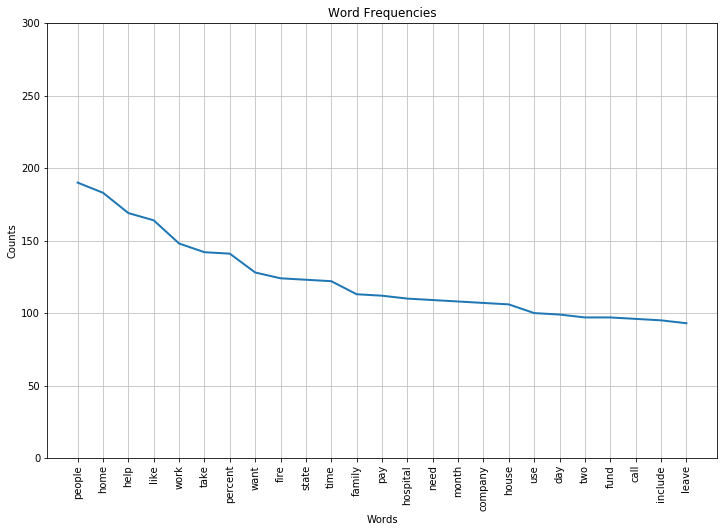

In [204]:
fig

From the business topic, we can see there more mention the words like san francisco, percentage, pg&e and also tax. There may be something happen related with pg&e in san francisco or california, and also talking about tax which may because of the date is close to the tax season. 

In [183]:
#local
Local = result.loc[result['Categroy'] == 'local']
#subset by categroy and put all text in one paragraph
text = ' '.join([x for x in local['text']])
# apply function on the text
text = Standardizing_Text(text)

#stop words
stopwords = nltk.corpus.stopwords.words("english") 
stopwords = stopwords + ['said','one','like','would','could','also','get','even','say','go','to','day','city','take','take','make']
text = [w for w in text if w not in stopwords]

# find freq words
local_fq = nltk.FreqDist(w for w in text if w.isalnum())
local_text = local_fq.most_common(25)

local_text

[('san', 261),
 ('francisco', 217),
 ('year', 216),
 ('people', 166),
 ('home', 153),
 ('help', 148),
 ('work', 126),
 ('fire', 112),
 ('family', 110),
 ('hospital', 110),
 ('want', 105),
 ('new', 103),
 ('house', 101),
 ('time', 99),
 ('pay', 94),
 ('need', 93),
 ('fund', 88),
 ('two', 86),
 ('month', 84),
 ('back', 83),
 ('call', 78),
 ('leave', 78),
 ('county', 77),
 ('police', 77),
 ('chronicle', 76)]

In [207]:
%%capture

# Create the Figure and plot.
fig = plt.figure(figsize = (12, 8))
local_fq.plot(25,cumulative = False)

# Get the Axes object from the Figure.
ax = fig.get_axes()[0]

# Customize as with any other matplotlib Axes
ax.set_title("Word Frequencies")
ax.set_xlabel("Words")
ax.set_ylim([0,300])


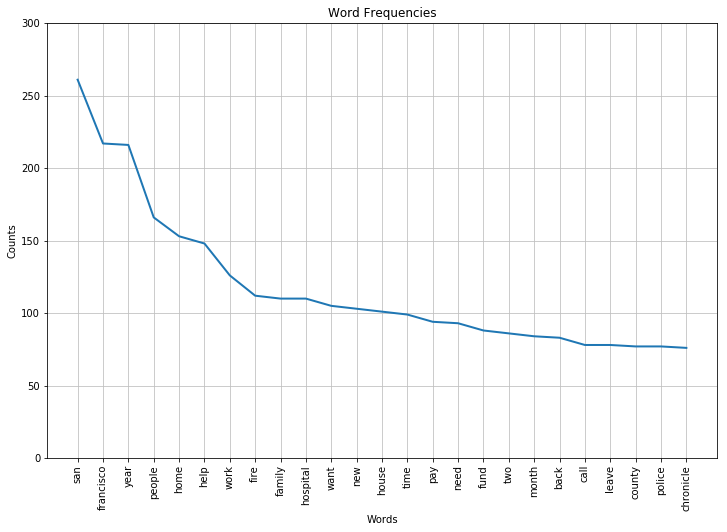

In [208]:
fig

From the local topic, we can see the words like work, home, fire, pay, family those word more happen in our daily conversition with friends. As well as san francisco, that means the topic more focus on the sf which close with us. 

In [209]:
#politics
politics = result.loc[result['Categroy'] == 'politics']
#subset by categroy and put all text in one paragraph
text = ' '.join([x for x in politics['text']])
# apply the function on text
text = Standardizing_Text(text)

#stop words
stopwords = nltk.corpus.stopwords.words("english") 
stopwords = stopwords + ['said','one','like','would','could','also','get','even','say','go','to','day','city','take','take','make','two']
text = [w for w in text if w not in stopwords]

# find the freq words
politics_fq = nltk.FreqDist(w for w in text if w.isalnum())
politics_text = politics_fq.most_common(25)

politics_text

[('state', 587),
 ('california', 463),
 ('year', 386),
 ('newsom', 382),
 ('san', 363),
 ('trump', 359),
 ('francisco', 303),
 ('democrat', 285),
 ('people', 285),
 ('new', 282),
 ('president', 272),
 ('work', 259),
 ('republican', 257),
 ('million', 240),
 ('brown', 233),
 ('governor', 227),
 ('house', 222),
 ('money', 218),
 ('campaign', 217),
 ('democratic', 212),
 ('vote', 212),
 ('time', 201),
 ('percent', 201),
 ('harris', 189),
 ('first', 185)]

In [214]:
%%capture

# Create the Figure and plot.
fig = plt.figure(figsize = (12, 8))
politics_fq.plot(25,cumulative = False)

# Get the Axes object from the Figure.
ax = fig.get_axes()[0]

# Customize as with any other matplotlib Axes
ax.set_title("Word Frequencies")
ax.set_xlabel("Words")
ax.set_ylim([0,650])

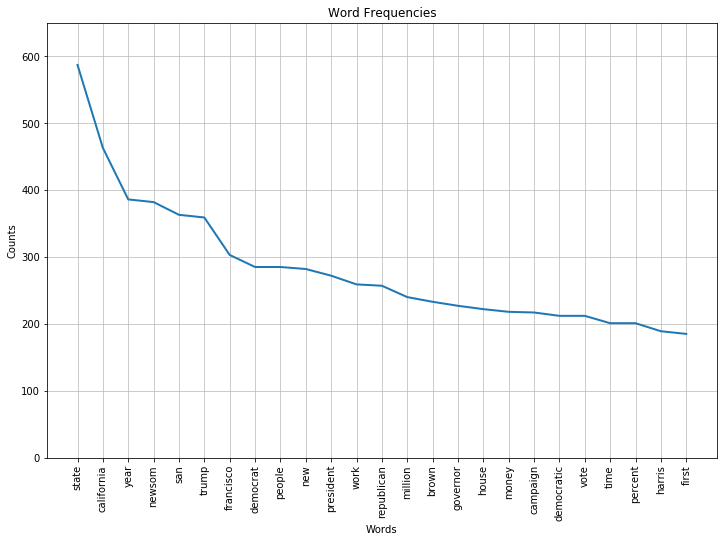

In [215]:
fig

For the politics topic we may see some words more like trump, state, democratic, republican, president, thry may talking about the president trump or parties stuff.

In [216]:
# comb all text
all_text = ' '.join([x for x in result['text']])
len(all_text)

# use Standardizing_Text() function to get all text in 3 categories 
all_text = Standardizing_Text(all_text)

#stop words
stopwords = nltk.corpus.stopwords.words("english") 
stopwords = stopwords + ['said',"the",'also','new','call','come','would','could','make','say','get','go','take','like','want','two','first','think']
all_text = [w for w in all_text if w not in stopwords]

# find freq words
fq = nltk.FreqDist(w for w in all_text if w.isalnum())
all_text = fq.most_common(25)
all_text

[('san', 933),
 ('year', 866),
 ('city', 818),
 ('francisco', 781),
 ('state', 780),
 ('one', 646),
 ('people', 641),
 ('california', 610),
 ('work', 533),
 ('help', 450),
 ('house', 429),
 ('time', 422),
 ('trump', 414),
 ('percent', 405),
 ('newsom', 403),
 ('home', 401),
 ('million', 384),
 ('money', 370),
 ('need', 364),
 ('president', 333),
 ('pay', 332),
 ('family', 325),
 ('democrat', 319),
 ('housing', 312),
 ('include', 310)]

In [222]:
%%capture

# Create the Figure and plot.
fig = plt.figure(figsize = (12, 8))
fq.plot(25,cumulative = False)

# Get the Axes object from the Figure.
ax = fig.get_axes()[0]

# Customize as with any other matplotlib Axes
ax.set_title("Word Frequencies")
ax.set_xlabel("Words")
ax.set_ylim([0,1000])

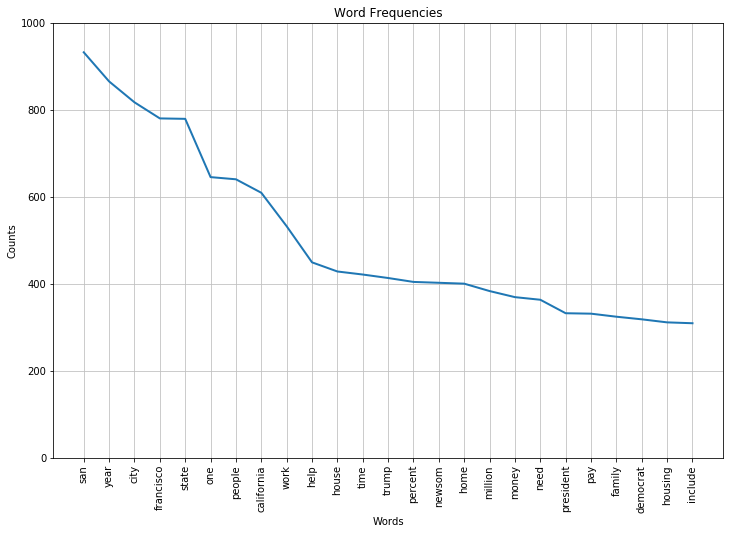

In [223]:
fig

From the word frequency of all text in 3 categories, we can see the most common words are "state","san francisco","california" those more represent the location which means the topic more locally that can easly connect with local people in California or SF. And also have the words like democrat, trump, work, house, those words more represent the thing about politics. the words like percentage, money is more close the busniess topic. 